$$\frac{d}{dx}\left(m_{uu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{uv}\frac{dv}{dx}\right)=f_1\qquad x\in\,(0,2\,\pi)$$
$$\frac{d}{dx}\left(m_{vu}\frac{du}{dx}\right)+\frac{d}{dx}\left(m_{vv}\frac{dv}{dx}\right)=f_2\qquad x\in\,(0,2\,\pi)$$

In [1]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csc_matrix
from scipy.sparse import diags
import scipy.sparse as sparse
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
# plt.style.use('tableau-colorblind10')
# plt.style.use('default')
import mylib

# import seaborn as sns
# sns.color_palette("dark")
# sns.set_theme(style="whitegrid")

def u_sol(x, kwargs):
    return np.exp(np.sin(x))

def du_soldx(x, kwargs):
    return np.cos(x)*np.exp(np.sin(x))

def d2u_soldx2(x, kwargs):
    return -np.sin(x)*np.exp(np.sin(x)) + np.square(np.cos(x))*np.exp(np.sin(x))


def v_sol(x, kwargs):
    return - np.square(x) + x - 1.0 

def dv_soldx(x, kwargs):
    return - 2.0*x + 1.0

def d2v_soldx2(x, kwargs):
    return - 2.0 + 0.0*x


def fmuu(x, kwargs):
    return kwargs['A'] + kwargs['B']*np.sin(kwargs['C']*x)

def dfmuudx(x, kwargs):
    return kwargs['B']*kwargs['C']*np.cos(kwargs['C']*x)


def fmuv(x, kwargs):
    return kwargs['D'] + kwargs['E']*x

def dfmuvdx(x, kwargs):
    return kwargs['E'] + 0.0*x


def fmvu(x, kwargs):
    return -fmuv(x, kwargs)

def dfmvudx(x, kwargs):
    return -dfmuvdx(x, kwargs)


def fmvv(x, kwargs):
    return kwargs['F'] + kwargs['G']*np.sin(kwargs['H']*x)

def dfmvvdx(x, kwargs):
    return kwargs['G']*kwargs['H']*np.cos(kwargs['H']*x)


def f_1(x, kwargs):
    return dfmuudx(x, kwargs)*du_soldx(x, kwargs) + fmuu(x, kwargs)*d2u_soldx2(x, kwargs) + dfmuvdx(x, kwargs)*dv_soldx(x, kwargs) + fmuv(x, kwargs)*d2v_soldx2(x, kwargs)

def f_2(x, kwargs):
    return dfmvudx(x, kwargs)*du_soldx(x, kwargs) + fmvu(x, kwargs)*d2u_soldx2(x, kwargs) + dfmvvdx(x, kwargs)*dv_soldx(x, kwargs) + fmvv(x, kwargs)*d2v_soldx2(x, kwargs)

cond(Z) = 370848.75485370285
monolithic error = 4.7004457108485364e-11


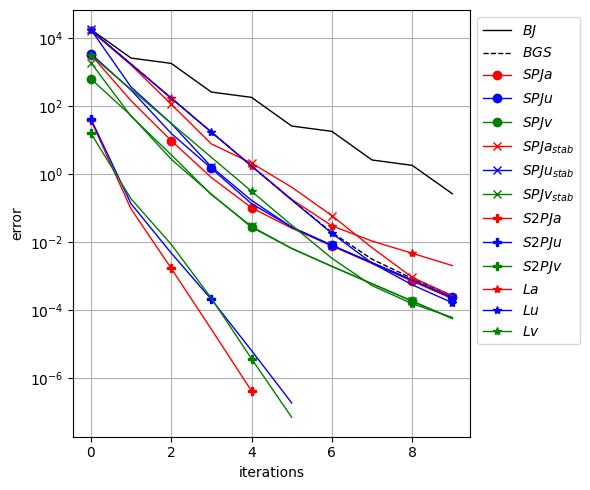

In [9]:
L = np.pi
N = 256
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)
nit_max = 10
toll = 1e-6

kwargs = {
    # muu coefficients
    'A': 1, #const
    'B': 0.5, #amplitude
    'C': 4.0, #frequency
    
    # muv=mvu coefficients
    'D': 1e-1, #const
    'E': 0, #slope
    
    # mvv coefficients
    'F': 1e-1, #const
    'G': 0.5e-1, #amplitude
    'H': 2  #frequency
    }

leftBC_u = {
    'type': 'dirichlet', #'type':'neumann',
    'value': u_sol(0.0, kwargs)}

rightBC_u = {
    'type': 'dirichlet', #'type':'neumann',
    'value': u_sol(L, kwargs)}

leftBC_v = {
    'type': 'dirichlet', #'type':'neumann',
    'value': v_sol(0.0, kwargs)}

rightBC_v = {
    'type': 'dirichlet', #'type':'neumann',
    'value': v_sol(L, kwargs)}

A, fuuBC = mylib.fvm_laplacian_1D(fmuu, leftBC_u, rightBC_u, N, L, kwargs)
B, fuvBC = mylib.fvm_laplacian_1D(fmuv, leftBC_v, rightBC_v, N, L, kwargs)
C, fvuBC = mylib.fvm_laplacian_1D(fmvu, leftBC_u, rightBC_u, N, L, kwargs)
D, fvvBC = mylib.fvm_laplacian_1D(fmvv, leftBC_v, rightBC_v, N, L, kwargs)

f1 = f_1(xc, kwargs) + fuuBC + fuvBC
f2 = f_2(xc, kwargs) + fvuBC + fvvBC

Z = np.zeros((2*N,2*N))
Z[:N,:N] = A.toarray()
Z[:N,N:] = B.toarray()
Z[N:,:N] = C.toarray()
Z[N:,N:] = D.toarray()
Z = sparse.csc_matrix(Z)
f = np.concatenate((f1, f2))
sol = sparse.linalg.spsolve(Z, f)
u = sol[:N]
v = sol[N:]
u_rec = mylib.fvm_reconstruct_1D(u)
v_rec = mylib.fvm_reconstruct_1D(v)

u_BJ,   v_BJ,   res_BJ,   nit_BJ   = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
u_BGS,  v_BGS,  res_BGS,  nit_BGS  = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)

u_SPJa, v_SPJa, res_SPJa, nit_SPJa = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu, v_SPJu, res_SPJu, nit_SPJu = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv, v_SPJv, res_SPJv, nit_SPJv = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')

u_SPJa_stab, v_SPJa_stab, res_SPJa_stab, nitfinal_SPJa_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_SPJu_stab, v_SPJu_stab, res_SPJu_stab, nitfinal_SPJu_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_SPJv_stab, v_SPJv_stab, res_SPJv_stab, nitfinal_SPJv_stab = mylib.method_SPJ_stab(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')

u_S2PJa, v_S2PJa, res_S2PJa, nit_S2PJa = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='alternate')
u_S2PJu, v_S2PJu, res_S2PJu, nit_S2PJu = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
u_S2PJv, v_S2PJv, res_S2PJv, nit_S2PJv = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')

u_La, v_La, res_La, nit_La = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="both",   Lu=-0.1, Lv=-0.1)
u_Lu, v_Lu, res_Lu, nit_Lu = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="L_on_u", Lu=-0.1, Lv=-0.1)
u_Lv, v_Lv, res_Lv, nit_Lv = mylib.method_Lscheme(A, B, C, D, f1, f2, nit_max, toll, type="L_on_v", Lu=-0.1, Lv=-0.1)

Z = Z.toarray()
A = A.toarray()
B = B.toarray()
C = C.toarray()
D = D.toarray()

print(f"cond(Z) = {np.linalg.cond(Z)}")
print(f"monolithic error = {np.linalg.norm(f-np.dot(Z,sol))}")

#####################################################################################################

linewidth = 1
markersize = 6
markevery = 1

plt.figure(dpi=100, figsize=(6,5))
nn = 5
plt.semilogy(res_BJ,        'k',   linestyle='solid',  label=r"$BJ$",          linewidth=linewidth, markersize=markersize, markevery=markevery+0)
plt.semilogy(res_BGS,       'k',   linestyle='dashed', label=r"$BGS$",         linewidth=linewidth, markersize=markersize, markevery=markevery+0)
plt.semilogy(res_SPJa,      'ro',  linestyle='solid',  label=r"$SPJa$",        linewidth=linewidth, markersize=markersize, markevery=markevery+1)
plt.semilogy(res_SPJu,      'bo',  linestyle='solid',  label=r"$SPJu$",        linewidth=linewidth, markersize=markersize, markevery=markevery+2)
plt.semilogy(res_SPJv,      'go',  linestyle='solid',  label=r"$SPJv$",        linewidth=linewidth, markersize=markersize, markevery=markevery+3)
plt.semilogy(res_SPJa_stab, 'rx',  linestyle='solid',  label=r"$SPJa_{stab}$", linewidth=linewidth, markersize=markersize, markevery=markevery+1)
plt.semilogy(res_SPJu_stab, 'bx',  linestyle='solid',  label=r"$SPJu_{stab}$", linewidth=linewidth, markersize=markersize, markevery=markevery+2)
plt.semilogy(res_SPJv_stab, 'gx',  linestyle='solid',  label=r"$SPJv_{stab}$", linewidth=linewidth, markersize=markersize, markevery=markevery+3)
plt.semilogy(res_S2PJa,     'rP',  linestyle='solid',  label=r"$S2PJa$",       linewidth=linewidth, markersize=markersize, markevery=markevery+1)
plt.semilogy(res_S2PJu,     'bP',  linestyle='solid',  label=r"$S2PJu$",       linewidth=linewidth, markersize=markersize, markevery=markevery+2)
plt.semilogy(res_S2PJv,     'gP',  linestyle='solid',  label=r"$S2PJv$",       linewidth=linewidth, markersize=markersize, markevery=markevery+3)
plt.semilogy(res_La,        'r*',  linestyle='solid',  label=r"$La$",          linewidth=linewidth, markersize=markersize, markevery=markevery+1)
plt.semilogy(res_Lu,        'b*',  linestyle='solid',  label=r"$Lu$",          linewidth=linewidth, markersize=markersize, markevery=markevery+2)
plt.semilogy(res_Lv,        'g*',  linestyle='solid',  label=r"$Lv$",          linewidth=linewidth, markersize=markersize, markevery=markevery+3)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()
plt.xlabel('iterations')
plt.ylabel('error')
# plt.savefig('figures/error2.pdf')

plt.tight_layout()
plt.show()


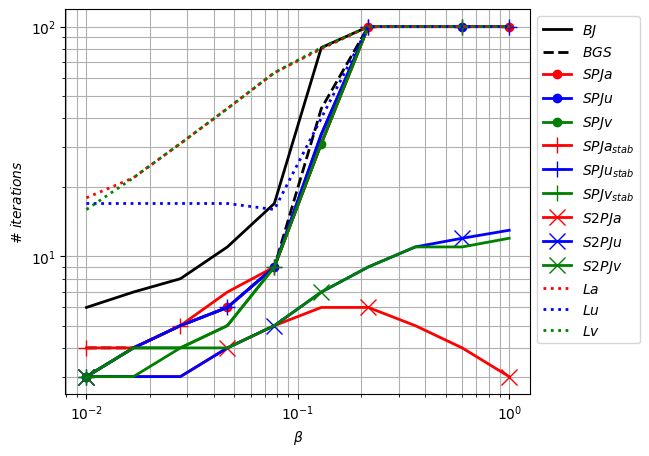

In [7]:
L = np.pi
N = 128
dx = np.divide(L, N)
x = np.linspace(0, L, N+1)
xc = np.linspace(0.5*dx, L-0.5*dx, N)
xfine = np.linspace(0, L, 1000)
omega = 1.0
nit_max = 100
toll = 1e-6

err = {
    "BJ":        {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BGS":       {"nit":[], "u_errl2":[], "v_errl2":[]},
    "BSOR":      {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJa":      {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJu":      {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJv":      {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJa_stab": {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJu_stab": {"nit":[], "u_errl2":[], "v_errl2":[]},
    "SPJv_stab": {"nit":[], "u_errl2":[], "v_errl2":[]},
    "La":        {"nit":[], "u_errl2":[], "v_errl2":[]},
    "Lu":        {"nit":[], "u_errl2":[], "v_errl2":[]},
    "Lv":        {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJa":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJu":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "S2PJv":     {"nit":[], "u_errl2":[], "v_errl2":[]},
    "mono":      {"u_errl2":[], "v_errl2":[]}
    }

# fig1, axs1 = plt.subplots(2, 1, figsize=(8,4), dpi=100, sharex=True)
# fig1, axs1 = plt.subplots(1, 1, figsize=(5,3), dpi=100)
# axs1.xaxis.set_major_formatter(plt.FuncFormatter(mylib.format_func))
# axs1.xaxis.set_major_locator(plt.MultipleLocator(np.pi / 2))
fig2, axs2 = plt.subplots(1, 1, figsize=(6,5), dpi=100)
# fig3, axs3 = plt.subplots(1, 1, figsize=(5,5), dpi=100)
markersize = 6
linewidth = 2
markevery = 1


beta = np.logspace(-2, 0, 10)
# beta = [0.001]
for val in beta:
    kwargs = {
    # muu coefficients
    'A': 1, #const
    'B': 0.5, #amplitude
    'C': 4.0, #frequency
    
    # muv=mvu coefficients
    'D': val, #const
    'E': 0, #slope
    
    # mvv coefficients
    'F': 1e-2/val, #const
    'G': 0.5e-2/val, #amplitude
    'H': 2  #frequency
    }

    leftBC_u = {
        'type': 'dirichlet', 
        'value': u_sol(0.0, kwargs)}

    rightBC_u = {
        'type': 'dirichlet', 
        'value': u_sol(L, kwargs)}

    leftBC_v = {
        'type': 'dirichlet', 
        'value': v_sol(0.0, kwargs)}

    rightBC_v = {
        'type': 'dirichlet', 
        'value': v_sol(L, kwargs)}

    A, fuuBC = mylib.fvm_laplacian_1D(fmuu, leftBC_u, rightBC_u, N, L, kwargs)
    B, fuvBC = mylib.fvm_laplacian_1D(fmuv, leftBC_v, rightBC_v, N, L, kwargs)
    C, fvuBC = mylib.fvm_laplacian_1D(fmvu, leftBC_u, rightBC_u, N, L, kwargs)
    D, fvvBC = mylib.fvm_laplacian_1D(fmvv, leftBC_v, rightBC_v, N, L, kwargs)

    f1 = f_1(xc, kwargs) + fuuBC + fuvBC
    f2 = f_2(xc, kwargs) + fvuBC + fvvBC

    Z = np.zeros((2*N,2*N))
    Z[:N,:N] = A.toarray()
    Z[:N,N:] = B.toarray()
    Z[N:,:N] = C.toarray()
    Z[N:,N:] = D.toarray()

    Z = sparse.csc_matrix(Z)
    f = np.concatenate((f1,f2))
    sol = sparse.linalg.spsolve(Z, f)
    u = sol[:N]
    v = sol[N:]
    u_rec = mylib.fvm_reconstruct_1D(u)
    v_rec = mylib.fvm_reconstruct_1D(v)


    u_BJ,        v_BJ,        res_BJ,        nitfinal_BJ        = mylib.method_BlockJacobi(          A, B, C, D, f1, f2, nit_max, toll)
    u_BGS,       v_BGS,       res_BGS,       nitfinal_BGS       = mylib.method_BlockGaussSeidel(     A, B, C, D, f1, f2, nit_max, toll)
    u_SPJa,      v_SPJa,      res_SPJa,      nitfinal_SPJa      = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_SPJu,      v_SPJu,      res_SPJu,      nitfinal_SPJu      = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_SPJv,      v_SPJv,      res_SPJv,      nitfinal_SPJv      = mylib.method_ShurPartialJacobi(    A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_SPJa_stab, v_SPJa_stab, res_SPJa_stab, nitfinal_SPJa_stab = mylib.method_SPJ_stab(             A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_SPJu_stab, v_SPJu_stab, res_SPJu_stab, nitfinal_SPJu_stab = mylib.method_SPJ_stab(             A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_SPJv_stab, v_SPJv_stab, res_SPJv_stab, nitfinal_SPJv_stab = mylib.method_SPJ_stab(             A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_S2PJa,     v_S2PJa,     res_S2PJa,     nitfinal_S2PJa     = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='alternate')
    u_S2PJu,     v_S2PJu,     res_S2PJu,     nitfinal_S2PJu     = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_u')
    u_S2PJv,     v_S2PJv,     res_S2PJv,     nitfinal_S2PJv     = mylib.method_ShurDualPartialJacobi(A, B, C, D, f1, f2, nit_max, toll, type='shur_on_v')
    u_La,        v_La,        res_La,        nitfinal_La        = mylib.method_Lscheme(              A, B, C, D, f1, f2, nit_max, toll, type="both",   Lu=-0.5, Lv=-0.5)
    u_Lu,        v_Lu,        res_Lu,        nitfinal_Lu        = mylib.method_Lscheme(              A, B, C, D, f1, f2, nit_max, toll, type="L_on_u", Lu=-0.5, Lv=-0.5)
    u_Lv,        v_Lv,        res_Lv,        nitfinal_Lv        = mylib.method_Lscheme(              A, B, C, D, f1, f2, nit_max, toll, type="L_on_v", Lu=-0.5, Lv=-0.5)
    
    err['mono']['u_errl2'].append((np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u))/np.linalg.norm(u_sol(x, kwargs))))
    err['mono']['v_errl2'].append((np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v))/np.linalg.norm(v_sol(x, kwargs))))

######################################

    Z = Z.toarray()
    A = A.toarray()
    B = B.toarray()
    C = C.toarray()
    D = D.toarray()

    err['BJ']['nit'].append(nitfinal_BJ)
    err['BJ']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BJ)))
    err['BJ']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BJ)))
    err['BGS']['nit'].append(nitfinal_BGS)
    err['BGS']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_BGS)))
    err['BGS']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_BGS)))
    err['SPJa']['nit'].append(nitfinal_SPJa)
    err['SPJa']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJa)))
    err['SPJa']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJa)))
    err['SPJu']['nit'].append(nitfinal_SPJu)
    err['SPJu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJu)))
    err['SPJu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJu)))
    err['SPJv']['nit'].append(nitfinal_SPJv)
    err['SPJv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJv)))
    err['SPJv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJv)))
    err['SPJa_stab']['nit'].append(nitfinal_SPJa_stab)
    err['SPJa_stab']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJa_stab)))
    err['SPJa_stab']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJa_stab)))
    err['SPJu_stab']['nit'].append(nitfinal_SPJu_stab)
    err['SPJu_stab']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJu_stab)))
    err['SPJu_stab']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJu_stab)))
    err['SPJv_stab']['nit'].append(nitfinal_SPJv_stab)
    err['SPJv_stab']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_SPJv_stab)))
    err['SPJv_stab']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_SPJv_stab)))
    err['S2PJa']['nit'].append(nitfinal_S2PJa)
    err['S2PJa']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJa)))
    err['S2PJa']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJa)))
    err['S2PJu']['nit'].append(nitfinal_S2PJu)
    err['S2PJu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJu)))
    err['S2PJu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJu)))
    err['S2PJv']['nit'].append(nitfinal_S2PJv)
    err['S2PJv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_S2PJv)))
    err['S2PJv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_S2PJv)))
    err['La']['nit'].append(nitfinal_La)
    err['La']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_La)))
    err['La']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_La)))
    err['Lu']['nit'].append(nitfinal_Lu)
    err['Lu']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_Lu)))
    err['Lu']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_Lu)))
    err['Lv']['nit'].append(nitfinal_Lv)
    err['Lv']['u_errl2'].append(np.linalg.norm(u_sol(x, kwargs)-mylib.fvm_reconstruct_1D(u_Lv)))
    err['Lv']['v_errl2'].append(np.linalg.norm(v_sol(x, kwargs)-mylib.fvm_reconstruct_1D(v_Lv)))

# axs1.plot(xfine, u_sol(xfine, kwargs), '-k', label=r'$u(x)$')
# axs1.plot(xfine, v_sol(xfine, kwargs), '--k', label=r'$u(x)$')
# axs1.grid()
# axs1.legend()
# # axs1[0].set_ylabel(r'$u$')
# # axs1[0].grid()
# # axs1[1].set_xlabel(r'$x$')
# # axs1[1].set_ylabel(r'$v$')
# # axs1[1].grid()
# # axs1[0].legend()
# # axs1[1].legend()
# fig1.savefig('./figures/ql_1D_beta_results.pdf')


axs2.loglog(beta, err['BJ']['nit'],       'k',  linestyle='solid',  label=r"$BJ$",          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.loglog(beta, err['BGS']['nit'],      'k',  linestyle='dashed', label=r"$BGS$",         linewidth=linewidth, markersize=markersize,   markevery=markevery+1)
axs2.loglog(beta, err['SPJa']['nit'],     'ro', linestyle='solid',  label=r"$SPJa$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+2)
axs2.loglog(beta, err['SPJu']['nit'],     'bo', linestyle='solid',  label=r"$SPJu$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+3)
axs2.loglog(beta, err['SPJv']['nit'],     'go', linestyle='solid',  label=r"$SPJv$",        linewidth=linewidth, markersize=markersize,   markevery=markevery+4)
axs2.loglog(beta, err['SPJa_stab']['nit'],'r+', linestyle='solid',  label=r"$SPJa_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+1)
axs2.loglog(beta, err['SPJu_stab']['nit'],'b+', linestyle='solid',  label=r"$SPJu_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+2)
axs2.loglog(beta, err['SPJv_stab']['nit'],'g+', linestyle='solid',  label=r"$SPJv_{stab}$", linewidth=linewidth, markersize=2*markersize, markevery=markevery+3)
axs2.loglog(beta, err['S2PJa']['nit'],    'rx', linestyle='solid',  label=r'$S2PJa$',       linewidth=linewidth, markersize=2*markersize, markevery=markevery+2)
axs2.loglog(beta, err['S2PJu']['nit'],    'bx', linestyle='solid',  label=r'$S2PJu$',       linewidth=linewidth, markersize=2*markersize, markevery=markevery+3)
axs2.loglog(beta, err['S2PJv']['nit'],    'gx', linestyle='solid',  label=r'$S2PJv$',       linewidth=linewidth, markersize=2*markersize, markevery=markevery+4)
axs2.loglog(beta, err['La']['nit'],        'r', linestyle='dotted', label=r'$La$',          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.loglog(beta, err['Lu']['nit'],        'b', linestyle='dotted', label=r'$Lu$',          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.loglog(beta, err['Lv']['nit'],        'g', linestyle='dotted', label=r'$Lv$',          linewidth=linewidth, markersize=markersize,   markevery=markevery+0)
axs2.set_xlabel(r"$\beta$")
axs2.set_ylabel(r"$\#~iterations$")
axs2.grid(which='both')
axs2.legend(bbox_to_anchor=(1, 1))
fig2.savefig('./figures/ql_1D_beta_it_100-1e-6.pdf')


# axs3.loglog(beta, err['mono']['u_errl2'], 's-', label=r'$Monolithic$')
# axs3.loglog(beta, err['BJ']['u_errl2'],   'k.-', label=r'$BJ$')
# axs3.loglog(beta, err['BGS']['u_errl2'],  'r.-', label=r'$BGS$')
# axs3.loglog(beta, err['SPJa']['u_errl2'], 'r>-', label=r'$SPJa$')
# axs3.loglog(beta, err['SPJu']['u_errl2'], 'b>-', label=r'$SPJu$')
# axs3.loglog(beta, err['SPJv']['u_errl2'], 'g>-', label=r'$SPJv$')
# # axs3.loglog(beta, err['La']['u_errl2'],   'rP-', label=r'$La$')
# # axs3.loglog(beta, err['Lu']['u_errl2'],   'bP-', label=r'$Lu$')
# # axs3.loglog(beta, err['Lv']['u_errl2'],   'gP-', label=r'$Lv$')
# axs3.loglog(beta, err['S2PJa']['u_errl2'], 'r3-', label=r'$S2PJa$', markersize=10)
# axs3.loglog(beta, err['S2PJu']['u_errl2'], 'b3-', label=r'$S2PJu$', markersize=10)
# axs3.loglog(beta, err['S2PJv']['u_errl2'], 'g3-', label=r'$S2PJv$', markersize=10)
# axs3.set_xlabel(r"$\beta$")
# axs3.set_ylabel(r"$||u(x_f)-u_h(x_f)||_{\mathbb{R}^N}$")#
# axs3.grid()
# axs3.legend()
# axs3.set_ylim(top=1)
# # fig3.savefig('./figures/dualporosity_varbeta_error-fixed-iterations-50.pdf')

plt.show()